In [34]:
# Imports
import re
import string
import numpy as np
import pandas as pd
from langdetect import detect

import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

import gensim

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_fscore_support as score

import torch
import torch.nn as nn
import torch.optim as optim

from gensim.models import Word2Vec

from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import PCA

from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import MiniBatchKMeans, KMeans

from datasets import Dataset as DS

from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, logging



## Reading and data preprocessing ##

In [2]:
# Read data
df = pd.read_csv('Dataset.csv')
print(df.head())

               song        artist  \
0         Let It Go     James Bay   
1      Love Someone  Lukas Graham   
2      Lose Control   Teddy Swims   
3  Beautiful Things  Benson Boone   
4     Make You Mine        PUBLIC   

                                              lyrics  sentiment  
0  From walking home and talking loads\nTo seeing...          0  
1  There are days\nI wake up and I pinch myself\n...          0  
2  Something's got a hold of me lately\nNo, I don...          0  
3  For a while there it was rough\nBut lately, I'...          0  
4  Girl, I will call you darling and everything w...          0  


In [3]:
# Main class for preprocessing
class Preprocessor:

    # Calculate the number of entries that got changed after processing
    def calculate_differences(self, p_list1, p_list2):

        # Number of changes after processing
        count = 0

        #Check how many fields got changed
        for i in range(len(p_list1)):
            if p_list1[i] != p_list2[i]:
                count += 1
        return count
    
    # Function that tags the part of speech
    def pos_tagger(self, nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:          
            return None
        
    # Remove elements thay are not character strings
    def remove_non_str_elements(self, p_list):

        print(f'### Remove elements that are no strings of characters: {sum([0 if isinstance(sentence,str) else 1 for sentence in p_list])} found')
        processed_list = [sentence if isinstance(sentence, str) else '' for sentence in p_list]

        return processed_list
    
    # Remove elements from a different languages than 'lg'
    def remove_different_lg_elem(self, p_list, lg = 'en'):

        # Number of elements from other languages
        detect_count = 0
        
        processed_list = [sentence if sentence != '' and detect(sentence) == 'en' else '' for sentence in p_list]

        for i in range(len(p_list)):
            if processed_list[i] != p_list[i]:
                detect_count += 1

        print(f'### Remove songs from different languages: {detect_count} found.')

        return processed_list
    
    # Remove punctuation from the elements
    def remove_punctuation(self, p_list):

        # String that contains punctuation, whitespace and extra unicode characters
        # 'RIGHT SINGLE QUATATION MARK'
        exclude = string.punctuation + '\u2019'

        processed_list = ["".join(['' if chr in exclude else chr for chr in sentence]) for sentence in p_list]
        print(f'### Remove punctuation')

        return processed_list
    
    # Convert elements to lower case
    def lower_case(self, p_list):
        processed_list = [sentence.lower() for sentence in p_list]
        print(f'### Converting to lowercase')
        return processed_list

    # Function that returns a lemmatized list
    def lemmatize_list(self, p_list):
        
        print("### Lemmatize content")
        # Returned lemmatized list
        processed_list = []
        # Instantiate the lemmatizer class
        lemmatizer = WordNetLemmatizer()

        for sentence in p_list:
            # Use pos_tag to get complete part of speech: 'DT', 'VBZ', 'VBG', ..
            pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
            # Process the tags in simpler versions for lemmatization: 'n', 'v', 'a', None, ..
            wordnet_tagged = list(map(lambda x: (x[0], self.pos_tagger(x[1])), pos_tagged))
            lemmatized_sentence = []
            for word, tag in wordnet_tagged:
                if tag is None:
                    # if there is no available tag, append the token as is
                    lemmatized_sentence.append(word)
                else:        
                    # else use the tag to lemmatize the token
                    lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
            lemmatized_sentence = " ".join(lemmatized_sentence)
            processed_list.append(lemmatized_sentence)

        return processed_list

    # Remove non-ascii characters
    def remove_non_ascii(self, p_list):
        print('### Removing non ascii characters')
        # List of availalble ascii characters
        printable = set(string.printable)
        # Filter non ascii characters
        processed_list = [''.join(filter(lambda x: x in printable, sentence)) for sentence in p_list]

        return processed_list

    # Functon that removes numbers from the strings
    def remove_numbers(self, p_list):
        occurences = sum([len(re.findall(r'[0-9]', sentence)) for sentence in p_list])
        processed_list = [re.sub(r'[0-9]', '', sentence) for sentence in p_list] 
        print(f'### Removing numbers: {occurences} found')
        return processed_list
        
    # Replace words with correct versions of them: we ll, do nt ..
    def replace_broken_words(self, p_list):
        print('### Replacing broken words')
        # Words that will be replaced
        replace_dict = {'ll' : 'will', 'nt' : 'not', 'm' : 'am', 've' : 'have', 'ca': 'can', 's' : 'is',
                        'wan' : 'wanna', 'na' : '', 'gon' : 'gonna', 're' : 'are', 'wo' : 'will', 'd' : 'would', 'u' : 'you'}
        # Final replaced lyrics
        processed_list = []
        for sentence in p_list:
            # Processed sentence
            processed_sentence = []
            for word in sentence.split():
                word = replace_dict.get(word, word)
                processed_sentence.append(word)
            processed_sentence = ' '.join(processed_sentence)
            processed_list.append(processed_sentence)
        return processed_list

    # Replacing extra characters to increase collision
    def replace_duplicate_letters(self, p_list):
        # Replacing extra characters
        print('### Replacing extra characters')
        # Replaces "aaaaaahhhhhhhaaaaaa" with "aahhaa"
        processed_list = [re.sub(r'([a-z])\1{3,}', r'\1\1', sentence) for sentence in p_list]
        # Replaces "ahaahaahaaha with "aha"
        #processed_list = [re.sub(r'(.+?)\1+', r'\1', sentence) for sentence in p_list]
        
        return processed_list

    # Replacing numbers with words
    def replace_numbers(self, p_list):
        occurences = sum([len(re.findall(r'[0-9]+', sentence)) for sentence in p_list])
        processed_list = [re.sub(r'x?[0-9]+(nd)?x?', 'NUMBER', sentence) for sentence in p_list]
        print(f'### Replacing numbers: {occurences} found')
        return processed_list

    def tokenize_sentences(self, p_sentences : list[str]):
        tokenized_sentences : list[list[str]] = [nltk.word_tokenize(sentence) for sentence in p_sentences]
        return tokenized_sentences

    # Main function for preprocessing
    def main(self, p_list, remove_non_strings=True, remove_non_english=True, remove_punctuation=True, lower_case=True, lemmatize=True,
             remove_numbers=True, broken_words=True, replace_extra=True, replace_numbers=True, remove_non_ascii=True, tokenize_sentences=False):
        print('## Preprocessing..')

        # Remove non string elements
        if remove_non_strings:
            preprocessed_list = self.remove_non_str_elements(p_list)

        # Remove elements that are in other languages than english
        if remove_non_english:
            preprocessed_list = self.remove_different_lg_elem(preprocessed_list)

        # Remove punctuation from elements
        if remove_punctuation:
            preprocessed_list = self.remove_punctuation(preprocessed_list)
                    
        # Convert characters to lowercase
        if lower_case:
            preprocessed_list = self.lower_case(preprocessed_list)

        # Lemmatize elements
        if lemmatize:
            preprocessed_list = self.lemmatize_list(preprocessed_list)

        # Remove numbers
        if remove_numbers:
            preprocessed_list = self.remove_numbers(preprocessed_list)

        # Replace broken words
        if broken_words:
            preprocessed_list = self.replace_broken_words(preprocessed_list)

        # Replace words with extra letters with simpler versions
        if replace_extra:
            preprocessed_list = self.replace_duplicate_letters(preprocessed_list)

        # Replace numbers with the work "NUMBER"
        if replace_numbers:
            preprocessed_list = self.replace_numbers(preprocessed_list)

        # Remove non ascii characters
        if remove_non_ascii:
            preprocessed_list = self.remove_non_ascii(preprocessed_list)

        if tokenize_sentences:
            preprocessed_list = self.tokenize_sentences(preprocessed_list)

        print()

        return preprocessed_list


## Data visualization ##

In [46]:
preprocessor = Preprocessor()

def remove_unavailable_data(p_df, p_label):
    p_df[p_label] = preprocessor.remove_non_str_elements(p_df[p_label])
    p_df = p_df.dropna(subset=[p_label])
    return p_df


12773
### Remove elements that are no strings of characters: 1 found
12773


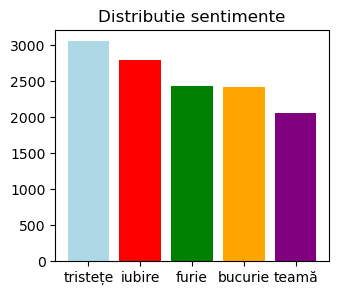

In [47]:
# Plot class distribution
sentiments = {'sad' : 0, 'love' :1, 'angry' : 2, 'happy' : 3, 'fear' : 4}
sentiment_names = ['tristețe', 'iubire', 'furie', 'bucurie', 'teamă']
sentiment_colors = ['lightblue', 'red', 'green', 'orange', 'purple']

visualization_df = df.copy()
visualization_df = remove_unavailable_data(visualization_df, 'lyrics')

sentiment_value_counts = visualization_df['sentiment'].value_counts().to_list()

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title('Distributie sentimente')
plt.bar(sentiment_names, sentiment_value_counts, color=sentiment_colors)
plt.show()


[56, 44, 44, 57, 37]


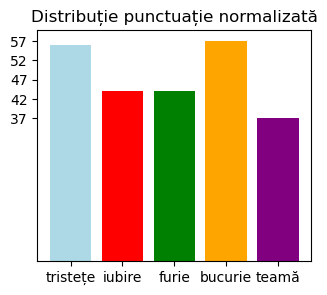

In [83]:
punctuation_dict = [{}, {}, {}, {}, {}]

def count_punctuation(p_data):
    punctuation_count_arr = []

    max_index = len(p_data['lyrics'])

    for idx in range(max_index):
        punctuation_count = 0
        for word in p_data['lyrics'][idx]:
            for character in word:
                if character in string.punctuation:
                    punctuation_count += 1
                    dict = punctuation_dict[p_data['sentiment'][idx]]
                    if dict.get(character, 0):
                        dict[character] += 1
                    else:
                        dict[character] = 1
                    punctuation_dict[p_data['sentiment'][idx]] = dict
        punctuation_count_arr.append(punctuation_count)
    return punctuation_count_arr


visualization_df['punctuation_count'] = count_punctuation(visualization_df[['lyrics', 'sentiment']])
visualization_df['punctuation_count'].head()

sentiment_punctuation_count_df = visualization_df[['sentiment', 'punctuation_count']]
grouping = sentiment_punctuation_count_df.groupby('sentiment').sum()

punctuation_count_per_sentiment_normalized = []
for index, value in enumerate(grouping['punctuation_count']):
    punctuation_count_per_sentiment_normalized.append(round(value / sentiment_value_counts[index]))
print(punctuation_count_per_sentiment_normalized)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title('Distribuție punctuație normalizată')
plt.bar(sentiment_names, punctuation_count_per_sentiment_normalized, color=sentiment_colors)
plt.yticks(np.arange(min(punctuation_count_per_sentiment_normalized), max(punctuation_count_per_sentiment_normalized)+1, 5))
plt.show()


In [84]:
print(punctuation_dict)

[{"'": 65076, ',': 55568, '?': 5209, '-': 7606, '.': 10917, '(': 9826, ')': 9823, '"': 1750, '!': 1634, ';': 231, ':': 876, '`': 68, '/': 32, '[': 1300, ']': 1301, '*': 225, '{': 105, '}': 105, '~': 4, '&': 37, '#': 3, '=': 1, '$': 5, '+': 19, '\\': 4, '_': 1}, {"'": 56687, '"': 1827, ',': 38348, '?': 5943, '(': 4758, ')': 4759, '-': 4579, '.': 4523, ';': 130, '!': 341, '&': 61, '[': 573, ']': 573, ':': 333, '*': 98, '\\': 2, '<': 3, '%': 10, '#': 2, '/': 10, '+': 1, '^': 2, '`': 48, '{': 20, '}': 20, '$': 1}, {"'": 35853, '(': 4566, ')': 4568, '?': 4032, ',': 31589, '[': 1222, ']': 1223, ':': 590, '/': 207, '.': 10650, '-': 6090, '!': 4532, ';': 104, '"': 937, '*': 214, '$': 3, '`': 66, '=': 30, '#': 5, '&': 73, '^': 4, '>': 2, '{': 4, '}': 4, '+': 9, '\\': 12, '_': 1, '%': 1}, {',': 44080, "'": 48758, '.': 9840, '(': 7696, ')': 7694, '!': 3780, '?': 3709, '-': 9767, ';': 173, '"': 1063, ':': 561, '$': 5, '[': 829, ']': 830, '{': 68, '}': 68, '&': 75, '*': 81, '~': 2, '/': 68, '`': 59

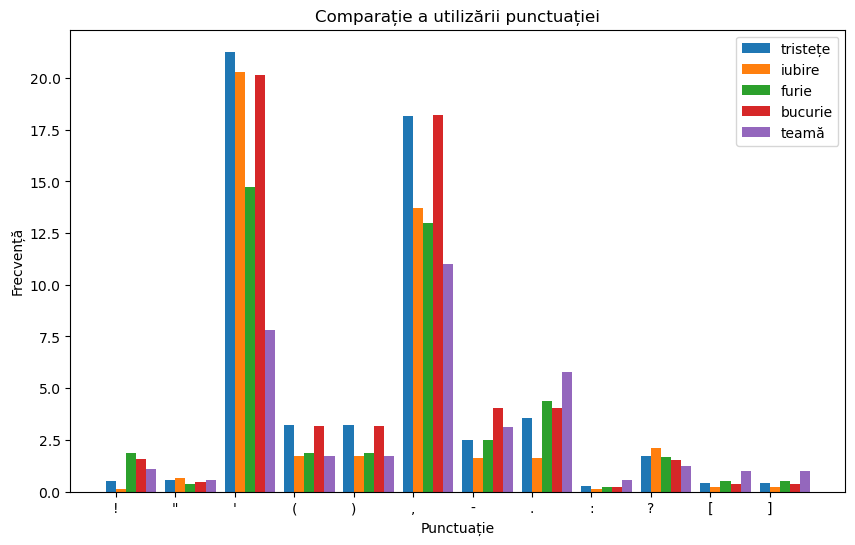

In [86]:
# Store dictionaries in a list for easy iteration

# Get all unique punctuation marks from all dictionaries
all_punctuations = set()
for d in punctuation_dict:
  for key in d.keys():
    if d[key] > 500:
      all_punctuations.add(key)

all_punctuations = sorted(all_punctuations)  # Ensure consistent order

# Prepare data for plotting
x = np.arange(len(all_punctuations))  # X-axis positions
width = 0.17  # Width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each dictionary as a group of bars
for i, d in enumerate(punctuation_dict):
    values = [d.get(p, 0)/sentiment_value_counts[i] for p in all_punctuations]  # Get counts, default to 0 if missing
    ax.bar(x + i * width, values, width=width, label=sentiment_names[i])

# Formatting the plot
ax.set_xlabel("Punctuație")
ax.set_ylabel("Frecvență")
ax.set_title("Comparație a utilizării punctuației")
ax.set_xticks(x + width / 2)  # Adjust x-ticks to center them
ax.set_xticklabels(all_punctuations)
ax.legend()

plt.show()

### Remove punctuation


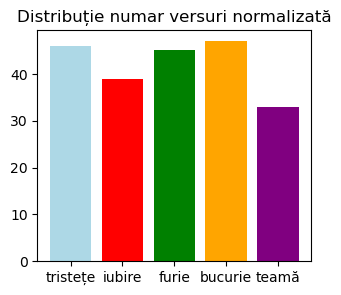

In [104]:
visualization_df['no_punctuation'] = preprocessor.remove_punctuation(visualization_df['lyrics'])

def count_newline(p_text):
    return len(re.findall('(\n)+', p_text))

visualization_df['newline_count'] = visualization_df['no_punctuation'].apply(count_newline)
sentiment_newline_group = visualization_df[['sentiment', 'newline_count']]
newline_grouping = sentiment_newline_group.groupby('sentiment').sum()

newline_count_per_sentiment_normalized = []
for idx, value in enumerate(newline_grouping['newline_count']):
    newline_count_per_sentiment_normalized.append(round(value / sentiment_value_counts[idx]))

visualization_df['no_newline'] = visualization_df['no_punctuation'].apply(lambda text: re.sub('(\n)+', ' ', text))

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title('Distribuție număr versuri normalizată')
plt.bar(sentiment_names, newline_count_per_sentiment_normalized, color=sentiment_colors)
# plt.yticks(np.arange(min(newline_count_per_sentiment_normalized), max(newline_count_per_sentiment_normalized)+1, 4))
plt.show()

In [105]:
visualization_df

0    From walking home and talking loads To seeing ...
1    There are days I wake up and I pinch myself Yo...
2    Somethings got a hold of me lately No I dont k...
3    For a while there it was rough But lately Ive ...
4    Girl I will call you darling and everything wi...
Name: no_newline, dtype: object


## Preprocessing ## 


In [4]:
# Cache-ing expensive data

preprocessor = Preprocessor() 

# Unprocessed lyrics
raw_lyrics = df['lyrics'].copy()

# Lyrics that are english only, not lematized
english_lyrics = preprocessor.remove_non_str_elements(df['lyrics'])
english_lyrics = preprocessor.remove_different_lg_elem(english_lyrics)

# Lyrics that are lemmatized
lemmatized_lyrics = preprocessor.lemmatize_list(english_lyrics)

### Remove elements that are no strings of characters: 1 found
### Remove songs from different languages: 439 found.
### Lemmatize content


In [5]:
# Concatenate song, artist, lyrics for a more complete evaluation.

lemmatized_df = df.copy()
lemmatized_df['lemmatized_lyrics'] = lemmatized_lyrics
lemmatized_df['complete_lyrics'] = 'song ' + lemmatized_df['song'] + ' artist ' + lemmatized_df['artist'] + ' lyrics ' + lemmatized_df['lemmatized_lyrics']
print('Complete lyrics: ')
print(lemmatized_df['complete_lyrics'].head())

Complete lyrics: 
0    song Let It Go artist James Bay lyrics From wa...
1    song Love Someone artist Lukas Graham lyrics T...
2    song Lose Control artist Teddy Swims lyrics So...
3    song Beautiful Things artist Benson Boone lyri...
4    song Make You Mine artist PUBLIC lyrics Girl ,...
Name: complete_lyrics, dtype: object


In [7]:
# Lyrics used for preprocessing
DATAFRAME = lemmatized_df
USED_LYRICS = lemmatized_df['complete_lyrics']

preprocessor = Preprocessor()

processed_lyrics =  preprocessor.main(USED_LYRICS, replace_numbers=False, remove_punctuation=True, remove_numbers=True, remove_non_english=False, lemmatize=False)
print(processed_lyrics[:10])


## Preprocessing..
### Remove elements that are no strings of characters: 0 found
### Remove punctuation
### Converting to lowercase
### Removing numbers: 10717 found
### Replacing broken words
### Replacing extra characters
### Removing non ascii characters

['song let it go artist james bay lyrics from walk home and talk load to see show in even clothes with you from nervous touch and get drunk to stay up and wake up with you now we are sleep near the edge holding something we do not need oh this delusion in our head is gonna  bring us to our knee so come on let it go just let it be why do not you be you and i will be me everything that is broke leave it to the breeze why do not you be you and i will be me and i will be me from throw clothes across the floor to teeth and claw and slam door at you if this be all we are live for why be we do it do it do it anymore i use to recognize myself it is funny how reflection change when we are become something else i think it is time to walk aw

In [8]:
# Processed dataset example
preprocessed_dataset = DATAFRAME.copy()
preprocessed_dataset['processed_lyrics'] = processed_lyrics
# Remove rows where lyrics were removed based on being preprocessed (dif. language, float..)
preprocessed_dataset.dropna(subset=['processed_lyrics'], inplace=True)

# Export dataset
vizualized_dataset = preprocessed_dataset.copy()
vizualized_dataset.drop(columns=['lyrics', 'lemmatized_lyrics', 'complete_lyrics'], inplace=True)
vizualized_dataset.to_csv('Preprocessed_Dataset.csv')


In [26]:
# Split data in train, val, test
# sentiments: 0 sad, 1 love, 2 angry, 3 happy, 4 scarry

sentiments = {'sad' : 0, 'love' :1, 'angry' : 2, 'happy' : 3, 'fear' : 4}

def get_data(p_dataset='default'):
    DATASET = preprocessed_dataset[['sentiment','processed_lyrics']].copy()
    DATASET.rename(columns={'sentiment':'label', 'processed_lyrics':'text'}, inplace=True)

    data, labels = [], []

    if p_dataset == 'happy_sad':
        happy_sad_df = DATASET[DATASET['label'].isin([sentiments['happy'], sentiments['sad']])].copy()
        data = happy_sad_df['text']
        labels = happy_sad_df['label']

    elif p_dataset == 'love_angry':
        love_angry_df = DATASET[DATASET['label'].isin([sentiments['love'], sentiments['angry']])].copy()
        data = love_angry_df['text']
        labels = love_angry_df['label']

    else:
        data = DATASET['text']
        labels = DATASET['label']

    X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.1, random_state=42, stratify=labels)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    return X_train, y_train, X_val, y_val, X_test, y_test

def get_text(p_dataset='default'):
    X_train, y_train, X_val, y_val, X_test, y_test = get_data(p_dataset)
    return X_train, X_val, X_test

def get_labels(p_dataset='default'):
    X_train, y_train, X_val, y_val, X_test, y_test = get_data(p_dataset)
    return y_train, y_val, y_test



## Embedding data ##


In [27]:
# Embbed data


'''
    Choose which vectorizer is used for data translation
    VECTORIZER : string = 'tfidf', 'word2vec'
'''

def data_embedding(p_vectorizer='tfidf', p_dataset='default'):

    X_train, X_val, X_test = get_text(p_dataset)

    # Embedding vectors used for tfidf
    Emb_train, Emb_val, Emb_test = [], [], []
    # Word2Vec vectorizer
    vectorizer = 'tfidf'

    def tfidf():
        vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, max_features=1000, stop_words='english')
        vectorizer.fit(X_train)
        Emb_train = vectorizer.transform(X_train)
        Emb_val = vectorizer.transform(X_val)
        Emb_test = vectorizer.transform(X_test)

        return Emb_train, Emb_val, Emb_test, vectorizer

    def word2vec(p_train):
        # Function that tokenizez sentences and removes stop words
        def preprocess_text(p_text):
            stop_words = set(stopwords.words('english'))
            # Tokenize data
            tokens = word_tokenize(p_text)
            # Remove stopwords
            tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
            return tokens
        # Preprocess sentences from corpus
        preprocessed_sentences = [preprocess_text(sentence) for sentence in p_train]

        # Instantiate word2vec vectorizer with 100 features
        vectorizer = Word2Vec(sentences=preprocessed_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)

        # Test 'word2vec' model
        try:
            similar_word_heart = vectorizer.wv.most_similar('heart', topn=5)
            print('Most similar word to heart: ', similar_word_heart)
        except KeyError as e:
            print(f"KeyError: {e}")
            
        return vectorizer

    if p_vectorizer == 'tfidf':
        Emb_train, Emb_val, Emb_test, vectorizer = tfidf()
        return Emb_train, Emb_val, Emb_test, vectorizer

    if p_vectorizer == 'word2vec':
        vectorizer = word2vec(X_train)
        return vectorizer
    
    raise Exception('Vectorizer option is not valid!')

### Word2vec testing

Word vectors:  [[-4.82582390e-01 -1.66905031e-01  3.65425386e-02 ...  5.64678060e-03
   3.97338837e-01 -8.10120400e-05]
 [-1.24363922e-01  1.48020327e-01 -3.38447541e-01 ... -2.96872735e-01
  -4.89193946e-02  3.64310071e-02]
 [-2.24800944e-01 -7.52348453e-02 -3.33521456e-01 ... -4.03071582e-01
   1.77716494e-01  1.01398878e-01]
 ...
 [-1.78250924e-01 -2.54777865e-03 -3.10040191e-02 ... -1.14516787e-01
   2.07464490e-02  8.53589475e-02]
 [-1.74688399e-01 -1.25962608e-02 -3.27890068e-02 ... -1.08318701e-01
   3.86717170e-02  9.31502059e-02]
 [-1.58953115e-01  1.48263285e-02 -2.67085359e-02 ... -7.78816044e-02
   3.12440563e-02  4.99593318e-02]]
Words:  ['get', 'know', 'love', 'like', 'go', 'na', 'oh', 'song', 'say', 'lyrics', 'yeah', 'artist', 'make', 'come', 'one', 'let', 'never', 'see', 'time', 'feel', 'take', 'cause', 'want', 'would', 'way', 'wan', 'life', 'baby', 'tell', 'need', 'back', 'think', 'gon', 'good', 'could', 'give', 'away', 'night', 'heart', 'right', 'ai', 'day', 'look', '

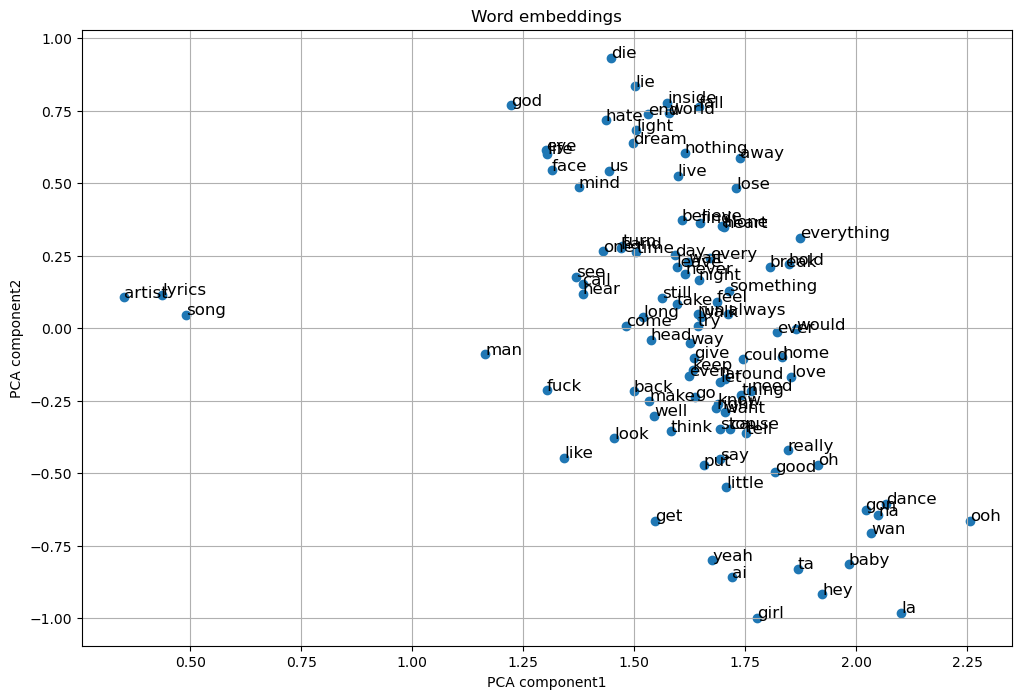

In [ ]:
# Plot word similarities based on word2vec
vectorizer = data_embedding(p_vectorizer='word2vec')

word_vectors = vectorizer.wv[vectorizer.wv.index_to_key]
print("Word vectors: ", word_vectors)
pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)

plt.figure(figsize=(12,8))
# Display colored points in space
plt.scatter(result[:100,0], result[:100,1])

words = list(vectorizer.wv.index_to_key)
print("Words: ", words)
for i, word in enumerate(words[:100]):
    plt.annotate(word, xy=(result[i,0], result[i,1]), fontsize=12)

plt.title("Word embeddings")
plt.xlabel("PCA component1")
plt.ylabel("PCA component2")
plt.grid()
plt.show()


In [21]:
# Tokenize and save data for word2vec
DATA = preprocessed_dataset['processed_lyrics']

preprocessor = Preprocessor()
tokenized_sentences = preprocessor.tokenize_sentences(DATA)

preprocessed_dataset['processed_tokenized_lyrics'] = tokenized_sentences

In [30]:
# Word2vec word processing

DATA = preprocessed_dataset['processed_lyrics']
LABELS = preprocessed_dataset['sentiment']
print('DATA:', DATA[:3])

def sentence_to_tensor(p_tokenized_sentence : list[str], p_w2v_model : Word2Vec, p_max_len : int):
    vectors = []
    for word in p_tokenized_sentence:
        if word in p_w2v_model.wv:
            vectors.append(p_w2v_model.wv[word])
        else:
            vectors.append(np.zeros(p_w2v_model.vector_size))

    while len(vectors) < p_max_len:
        vectors.append(np.zeros(p_w2v_model.vector_size))

    return torch.tensor(vectors[:p_max_len], dtype=torch.float)

Y_tensors = torch.tensor(LABELS, dtype=torch.long)
SPLIT_VALUE_TRAIN = 0.8
SPLIT_VALUE_TEST = 0.1

train_limit_index = round(len(tokenized_sentences) * SPLIT_VALUE_TRAIN)
Emb_train = torch.stack([sentence_to_tensor(sentence, vectorizer, 50) for sentence in tokenized_sentences[:train_limit_index]])
y_train = Y_tensors[:train_limit_index]
print('Emb_train.shape: ',Emb_train.shape)

test_validation_samples = len(tokenized_sentences)-train_limit_index
# After train the rest of the data is split in half.
validation_samples =  test_validation_samples // 2
validation_limit_index= train_limit_index + validation_samples
Emb_val= torch.stack([sentence_to_tensor(sentence, vectorizer, 50) for sentence in tokenized_sentences[train_limit_index:validation_limit_index]])
print('Emb_val.shape: ', Emb_val.shape)
y_val = Y_tensors[train_limit_index:validation_limit_index]

Emb_test = torch.stack([sentence_to_tensor(sentence, vectorizer, 50) for sentence in tokenized_sentences[validation_limit_index:]])
print('Emb_test.shape: ', Emb_test.shape)
y_test = Y_tensors[validation_limit_index:]



DATA: 0    song let it go artist james bay lyrics from wa...
1    song love someone artist lukas graham lyrics t...
2    song lose control artist teddy swims lyrics so...
Name: processed_lyrics, dtype: object
Emb_train.shape:  torch.Size([10218, 50, 100])
Emb_val.shape:  torch.Size([1277, 50, 100])
Emb_test.shape:  torch.Size([1278, 50, 100])


<h2> ## Logistic Regression Model ## </h2> 

In [40]:
# Heat map function for visualization
def plot_heat_map(p_pred, p_truth, p_labels, p_ticklabels):
    
    cm = confusion_matrix(p_truth, p_pred, labels=p_labels)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    # Sentiment: 0=Sad, 1=Love, 2=Anger, 3=Happy, 4=Fear 
    ax.xaxis.set_ticklabels(['Sadness','Happiness']); ax.yaxis.set_ticklabels(['Sadness','Happiness'])

def print_results(pred_train, y_train, pred_val, y_val, pred_test, y_test):
    # Validate model on train, test, validation sets

    print('## Train results')
    print(classification_report(pred_train, y_train, digits=4))


    print('## Validation results')
    print(classification_report(pred_val, y_val, digits=4))


    print('## Test results')
    print(classification_report(pred_test, y_test, digits=4))



### Happy-sad dataset

c:\Users\admin\anaconda3\envs\cristiiii\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


## Train results
              precision    recall  f1-score   support

           0     0.8328    0.8076    0.8200      2838
           3     0.7495    0.7803    0.7646      2094

    accuracy                         0.7960      4932
   macro avg     0.7912    0.7940    0.7923      4932
weighted avg     0.7975    0.7960    0.7965      4932

## Validation results
              precision    recall  f1-score   support

           0     0.7190    0.7143    0.7166       154
           3     0.6364    0.6417    0.6390       120

    accuracy                         0.6825       274
   macro avg     0.6777    0.6780    0.6778       274
weighted avg     0.6828    0.6825    0.6826       274

## Test results
              precision    recall  f1-score   support

           0     0.7190    0.6748    0.6962       163
           3     0.5620    0.6126    0.5862       111

    accuracy                         0.6496       274
   macro avg     0.6405    0.6437    0.6412       274
weighted avg     0.

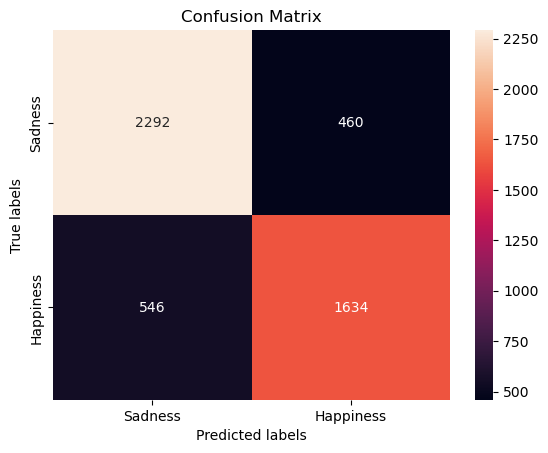

In [64]:
DATASET = 'happy_sad'
Emb_train, Emb_val, Emb_test, vectorizer = data_embedding(p_vectorizer='tfidf', p_dataset=DATASET)
y_train, y_val, y_test = get_labels(DATASET)

model = LogisticRegression(random_state=42, max_iter=4000)


def grid_search():

    param_grid = {'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] ,
                'penalty' : ['l1', 'l2', 'elasticnet', None], 'C':[1, 0.1, 0.5, 2, 5, 10]}

    log_reg_cv = GridSearchCV(model, param_grid, cv=10, verbose=3)
    log_reg_cv.fit(Emb_train,y_train)


    print("tuned hpyerparameters :(best parameters) ",log_reg_cv.best_params_)
    print("accuracy :",log_reg_cv.best_score_)


def single_evaluation():
    model = LogisticRegression(random_state=42, max_iter=4000, C=10, solver='newton-cg', penalty=None)
    model.fit(Emb_train, y_train)

    pred_train = model.predict(Emb_train)
    pred_val = model.predict(Emb_val)
    pred_test = model.predict(Emb_test)


    print_results(pred_train, y_train, pred_val, y_val, pred_test, y_test)

    plot_heat_map(pred_train, y_train, p_labels=[0,3], p_ticklabels=['sadness','happiness'])

single_evaluation()
# grid_search()


### 5 Classes

In [22]:
# Use logistic regression model

'''
    Calculate the benchmark for the model without further changes
      TRAIN       precision  recall    f1-score
     macro avg     0.7732    0.7774    0.7733     
'''
Emb_train, Emb_val, Emb_test, vectorizer = data_embedding(p_vectorizer='tfidf')

model = LogisticRegression(random_state=42, multi_class='multinomial')
model.fit(Emb_train, y_train)

# Validate model on train, test, validation sets
train_pred = model.predict(Emb_train)
print('## Train results')
print(classification_report(train_pred, y_train, digits=4))

val_pred = model.predict(Emb_val)
print('## Validation results')
print(classification_report(val_pred, y_val, digits=4))

test_pred = model.predict(Emb_test)
print('## Test results')
print(classification_report(test_pred, y_test, digits=4))

'''
  #TO DO: Move this to a Visualizer class
'''
# Function that prints a heatmap to check failure distribution, pred=list(Predicted labels), truth=list(Real labels)
def plot_heat_map(p_pred, p_truth, p_labels=[0,1,2,3,4]):
    
    cm = confusion_matrix(p_truth, p_pred, labels=p_labels)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    # Sentiment: 0=Sad, 1=Love, 2=Anger, 3=Happy, 4=Fear 
    ax.xaxis.set_ticklabels(['Sad', 'Love', 'Anger', 'Happiness', 'Fear']); ax.yaxis.set_ticklabels(['Sad', 'Love', 'Anger', 'Happiness', 'Fear'])

c:\Users\admin\anaconda3\envs\cristiiii\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Train results
              precision    recall  f1-score   support

           0     0.6188    0.5889    0.6035      2892
           1     0.6540    0.6499    0.6520      2205
           2     0.6908    0.5968    0.6404      2912
           3     0.4518    0.5804    0.5081      1697
           4     0.7775    0.8066    0.7918      1789

    accuracy                         0.6352     11495
   macro avg     0.6386    0.6445    0.6391     11495
weighted avg     0.6438    0.6352    0.6374     11495

## Validation results
              precision    recall  f1-score   support

           0     0.5490    0.4541    0.4970       185
           1     0.5082    0.5391    0.5232       115
           2     0.5786    0.5192    0.5473       156
           3     0.3802    0.5111    0.4360        90
           4     0.7282    0.8065    0.7653        93

    accuracy                         0.5446       639
   macro avg     0.5488    0.5660    0.5538       639
weighted avg     0.5512    0.5446    0

## Heat map for model evaluation, we want to see what are the most made mistakes

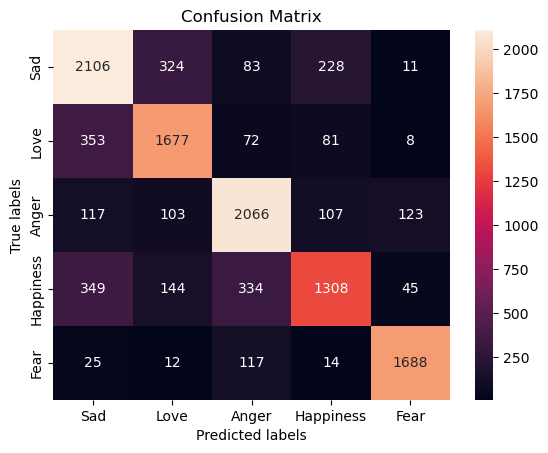

In [138]:
# Evaluate for train
plot_heat_map(train_pred, y_train)

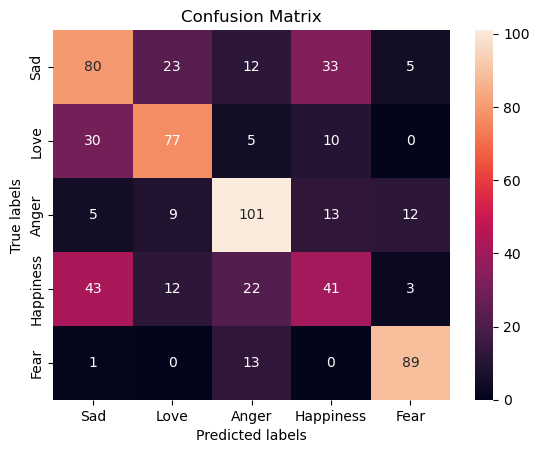

In [139]:
# Evaluate for test
plot_heat_map(test_pred, y_test)

## ## K nearest neighbours ## ##

In [140]:
# Initialize KNN classifier
model = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=2)
model.fit(Emb_train, y_train)

# Predict and report for train
train_pred = model.predict(Emb_train)
print(classification_report(train_pred, y_train))

# Predict and report for val
val_pred = model.predict(Emb_val)
print(classification_report(val_pred, y_val))

# Predict and report for test
test_pred = model.predict(Emb_test)
print(classification_report(test_pred, y_test))


              precision    recall  f1-score   support

           0       0.79      0.52      0.63      4213
           1       0.70      0.62      0.66      2478
           2       0.57      0.77      0.66      1850
           3       0.54      0.77      0.64      1529
           4       0.71      0.92      0.80      1425

    accuracy                           0.66     11495
   macro avg       0.66      0.72      0.68     11495
weighted avg       0.69      0.66      0.66     11495

              precision    recall  f1-score   support

           0       0.56      0.35      0.43       245
           1       0.48      0.36      0.41       165
           2       0.33      0.49      0.39        94
           3       0.37      0.58      0.45        78
           4       0.50      0.89      0.64        57

    accuracy                           0.45       639
   macro avg       0.45      0.53      0.47       639
weighted avg       0.48      0.45      0.44       639

              precisio

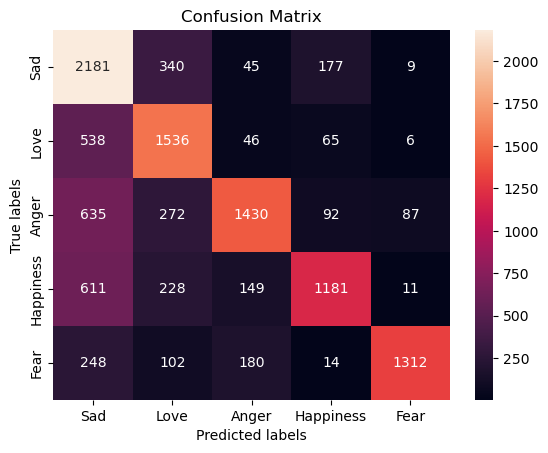

In [141]:
# Evaluate for train
plot_heat_map(train_pred, y_train)

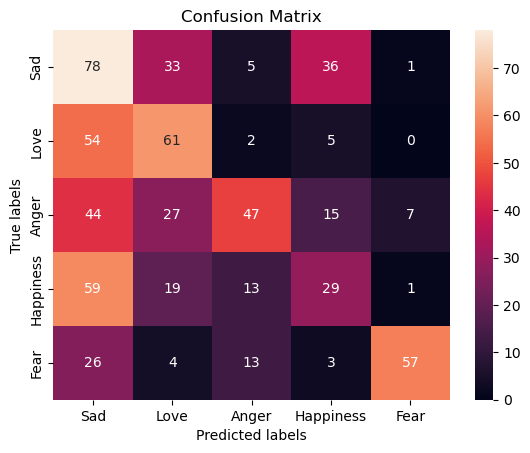

In [142]:
# Evaluate for test
plot_heat_map(test_pred, y_test)

## ## Service Vector Machine (SVM) ## ##


In [144]:
model = svm.LinearSVC()
model.fit(Emb_train, y_train)

# Predict and report for train
train_pred = model.predict(Emb_train)
print(classification_report(train_pred, y_train))

# Predict and report for val
val_pred = model.predict(Emb_val)
print(classification_report(val_pred, y_val))

# Predict and report for test
test_pred = model.predict(Emb_test)
print(classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2741
           1       0.89      0.85      0.87      2301
           2       0.92      0.92      0.92      2537
           3       0.82      0.88      0.85      2048
           4       0.98      0.97      0.97      1868

    accuracy                           0.89     11495
   macro avg       0.89      0.89      0.89     11495
weighted avg       0.89      0.89      0.89     11495

              precision    recall  f1-score   support

           0       0.57      0.53      0.55       163
           1       0.62      0.64      0.63       118
           2       0.64      0.62      0.63       146
           3       0.52      0.58      0.55       109
           4       0.84      0.84      0.84       103

    accuracy                           0.63       639
   macro avg       0.64      0.64      0.64       639
weighted avg       0.63      0.63      0.63       639

              precisio

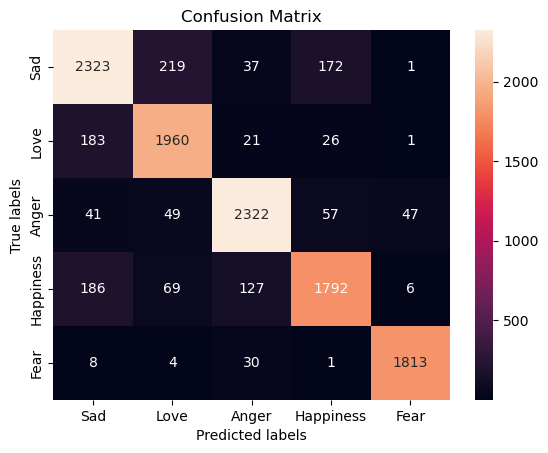

In [145]:
# Evaluate for train
plot_heat_map(train_pred, y_train)

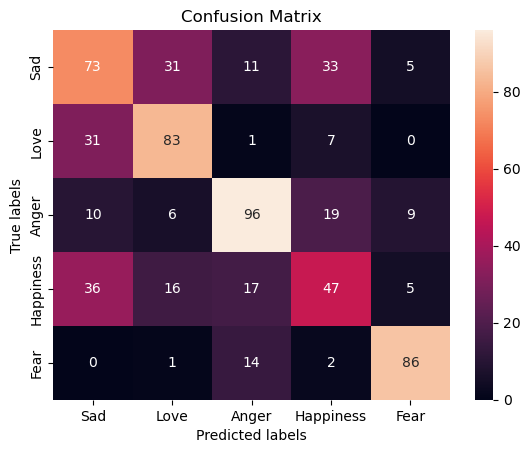

In [146]:
# Evaluate for test
plot_heat_map(test_pred, y_test)

## ## Long Short Term Memory model(LSTM) ## ##

In [68]:
# Making data_loaders for the LSTM model
W2V_MODEL = vectorizer

X_train, y_train, X_test, y_test, X_val, y_val = list(map(lambda dataset: dataset.to_numpy(), [X_train, y_train, X_test, y_test, X_val, y_val]))

class TextDataset(Dataset):
    def __init__(self, sentences, labels, w2v_model, max_len=50):
        self. sentences = sentences
        self.labels = labels
        self.w2v_model = w2v_model
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):
        sentence = self.sentences[index]
        label = self.labels[index]
        tensor = sentence_to_tensor(sentence, self.w2v_model, self.max_len)
        return tensor, torch.tensor(label, dtype=torch.long) 


train_dataset = TextDataset(X_train, y_train, W2V_MODEL, max_len=50)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

val_dataset = TextDataset(X_val, y_val, W2V_MODEL, max_len=50)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = TextDataset(X_test, y_test, W2V_MODEL, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [69]:

class LSTMClassfier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMClassfier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out
    
model = LSTMClassfier(input_dim=100, hidden_dim=128, output_dim=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss:{epoch_loss / len(train_loader):.4f}')

Epoch 1, Loss:1.3915
Epoch 2, Loss:1.3188
Epoch 3, Loss:1.2580
Epoch 4, Loss:1.2421
Epoch 5, Loss:1.2015
Epoch 6, Loss:1.1703
Epoch 7, Loss:1.1476
Epoch 8, Loss:1.1244
Epoch 9, Loss:1.0950
Epoch 10, Loss:1.0719


In [70]:
def evaluate(model, data_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            outputs = model(x_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.tolist())
            y_pred.extend(predicted.tolist())
    print(classification_report(y_true, y_pred))

evaluate(model, train_loader)
evaluate(model, val_loader)
evaluate(model, test_loader)


              precision    recall  f1-score   support

           0       0.47      0.50      0.48      2752
           1       0.51      0.60      0.55      2191
           2       0.57      0.60      0.59      2516
           3       0.56      0.27      0.37      2180
           4       0.71      0.88      0.78      1856

    accuracy                           0.56     11495
   macro avg       0.56      0.57      0.55     11495
weighted avg       0.56      0.56      0.55     11495

              precision    recall  f1-score   support

           0       0.44      0.44      0.44       153
           1       0.50      0.57      0.53       122
           2       0.58      0.66      0.62       140
           3       0.55      0.30      0.39       121
           4       0.72      0.82      0.76       103

    accuracy                           0.55       639
   macro avg       0.55      0.56      0.55       639
weighted avg       0.54      0.55      0.54       639

              precisio

## ## Clustering (Kmeans) ## ##

In [79]:
# MAYBE USE WITH PCA
def sentence_to_vectors(p_tokenized_sentence : list[str], p_w2v_model : Word2Vec, p_max_len : int):
    vectors = []
    for word in p_tokenized_sentence:
        if word in p_w2v_model.wv:
            vectors.append(p_w2v_model.wv[word])
        else:
            vectors.append(np.zeros(p_w2v_model.vector_size))

    while len(vectors) < p_max_len:
        vectors.append(np.zeros(p_w2v_model.vector_size))

    return np.array(vectors[:p_max_len])

Emb_train = np.array([sentence_to_vectors(sentence, vectorizer, p_max_len=50) for sentence in X_train])
print(Emb_train[:5])

[[[ 0.55435073  0.26952657 -0.34217587 ... -0.48460481  0.28909892
    0.24789606]
  [-0.09785017  0.01166884 -0.21116105 ... -0.11322016  0.0911286
    0.09094397]
  [-0.21615213 -0.08936872 -0.04883042 ... -0.11410993  0.23919834
    0.05119177]
  ...
  [-0.16108821  0.00761792 -0.04393903 ... -0.08439475  0.01210188
    0.1001522 ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.55435073  0.26952657 -0.34217587 ... -0.48460481  0.28909892
    0.24789606]
  [-0.30236331  0.04119946 -0.03900969 ... -0.1067189  -0.01626236
    0.19949649]
  [-0.36078712 -0.28205958 -0.0279763  ... -0.25074428  0.07726898
    0.25323984]
  ...
  [-0.16301493 -0.08385484 -0.27764285 ... -0.23633596 -0.12080368
    0.1562092 ]
  [-0.58243477  0.06297123 -0.25545007 ...  0.71933234  0.50628257
   -0.46572495]
  [ 0.35026079 -0.46713346 -0.12859537 ... -0.28162417  0.32358095
   -0.16826259]]

 [[ 0

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters


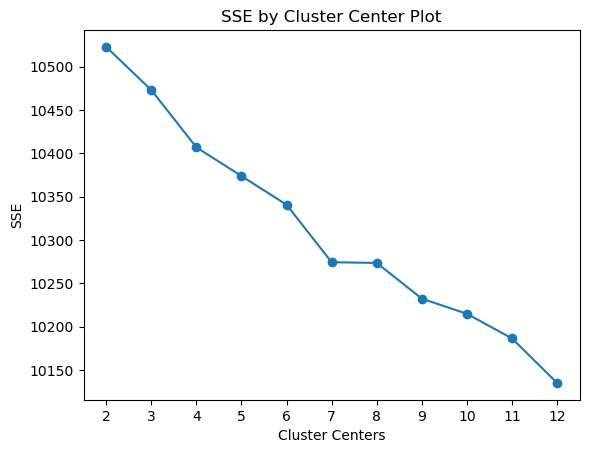

In [45]:
DATA = Emb_train

def find_optimal_clusters(p_data, p_max_k):
    iters = range(2, p_max_k+1)

    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=42).fit(p_data).inertia_)
        print('Fit {} clusters'.format(k))

    f, ax = plt.subplots(1,1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

find_optimal_clusters(DATA, 12)
    



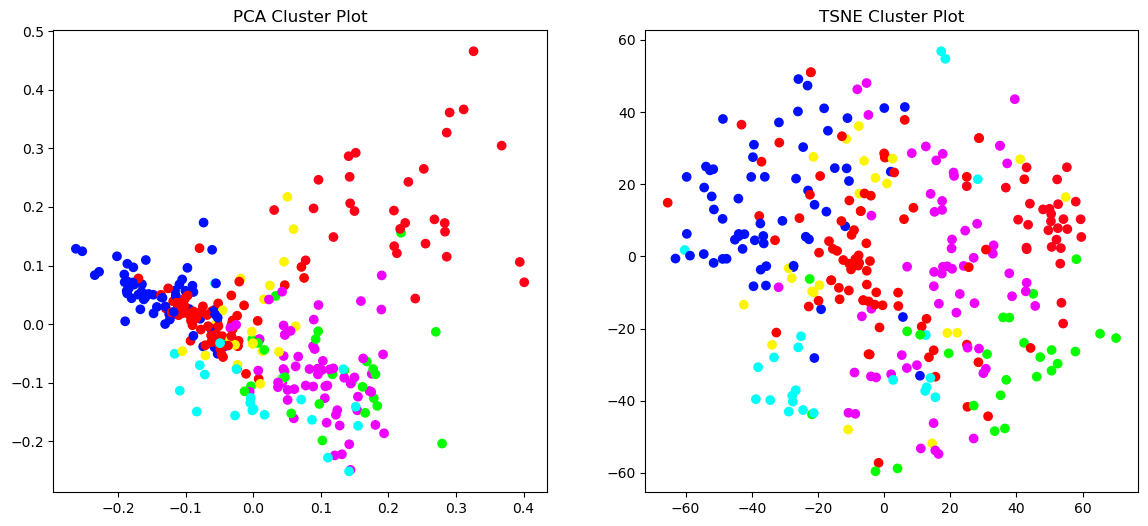

In [78]:
clusters = MiniBatchKMeans(n_clusters=7, init_size=1024, batch_size=2024, random_state=42).fit_predict(DATA)

def plot_tsne_pca(p_data, p_labels):
    p_data = p_data.toarray()
    max_label = max(p_labels)
    max_items = np.random.choice(range(p_data.shape[0]), size=3000, replace=False)

    pca = PCA(n_components=2)
    pca = pca.fit_transform(p_data[max_items,:])
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(p_data[max_items,:]))

    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = p_labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

    

plot_tsne_pca(DATA, clusters)

In [84]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(DATA, clusters, vectorizer.get_feature_names_out(), 10)


Cluster 0
dream,away,let,man,just,make,know,like,come,night

Cluster 1
forever,like,away,just,know,come,good,life,day,time

Cluster 2
say,hey,baby,like,know,dance,yeah,gonna,ooh,oh

Cluster 3
know,just,ai,nigga,like,shit,bitch,la,yeah,fuck

Cluster 4
world,hell,pain,god,soul,dead,blood,die,life,death

Cluster 5
cause,make,want,feel,wanna,let,say,like,just,know

Cluster 6
let,just,oh,need,like,heart,baby,say,know,love


## ## Pretrained models ## ##

In [8]:
# pretrained_model = "distilbert-base-uncased" # checked - works well
# pretrained_model = "google/electra-base-discriminator" # checked - works well
# pretrained_model = "google/electra-base-generator" # checked - works well
# pretrained_model = "bert-base-uncased" # checked - works well
pretrained_model = "microsoft/MiniLM-L12-H384-uncased" # checked - works well

In [ ]:
# Split data in train, test, validation for transformers
DATA = preprocessed_dataset[['sentiment', 'processed_lyrics']].copy()
DATA = DATA.rename(columns={'processed_lyrics': 'text', 'sentiment' : 'label'})

print('DATA: {}'.format(DATA.head()))
print('DATA: ', DATA.shape)

def trim_text(p_text, p_max_len=400):
    text_words = p_text.split()
    if len(text_words) > p_max_len:
        return " ".join(text_words[:p_max_len])
    
    return p_text

DATA['text'] = DATA['text'].apply(trim_text)


train_df, temp_df = train_test_split(DATA, test_size = 0.1, random_state = 42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)



DATA:    label                                               text
0      0  song let it go artist james bay lyrics from wa...
1      0  song love someone artist lukas graham lyrics t...
2      0  song lose control artist teddy swims lyrics so...
3      0  song beautiful things artist benson boone lyri...
4      0  song make you mine artist public lyrics girl i...
DATA:  (12773, 2)


In [14]:
# Tokenize the text
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

def preprocess_function(examples):
    """
    Tokenize the text to create input and attention data
    
    in -> dataset (columns = text, label)
    out -> tokenized dataset (columns = text, label, input, attention)
    """
    return tokenizer(examples['text'], truncation=True)


def pipeline(dataframe):
    """
    Prepares the dataframe so that it can be given to the transformer model
    
    in -> pandas dataframe
    out -> tokenized dataset (columns = text, label, input, attention)
    """    
    # This step isn't mentioned anywhere but is vital as Transformers library only seems to work with this Dataset data type
    dataset = DS.from_pandas(dataframe, preserve_index=False)
    print('Pre-processing dataset: ', dataset[:5])
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    print('Post processing dataset: ', dataset[:5])
    tokenized_ds = tokenized_ds.remove_columns('text')
    return tokenized_ds

In [15]:
tokenized_train = pipeline(train_df)
print('tokenized_train: ', tokenized_train)
tokenized_val = pipeline(val_df)
print('tokenized_val: ', tokenized_val)

Pre-processing dataset:  {'label': [0, 0, 1, 1, 0], 'text': ['song somethings got a hold on me artist etta james lyrics something is got a hold on me vaya con dios sometimes i get a good feeling i get a feeling that i never never have before and i get to tell you right now i believe i really do believe that something is get a hold on me oh it must be love something is get a hold on me right now child yeah it must be love let me tell you now i never felt like this before something is get a hold on me that will not let go i believe i would die if i only could i sure feel strange but i sure feel good i say oh yeah it must be love you know it must be love let me tell you now something is get a hold on me oh it must be love something is get a hold on me right now child yeah it must be love let me tell you now i get a feeling i feel so strange everything about me seem to have change step by step i get a brand new walk i even sound sweet when i talk i say oh yeah it must be love you know it m

Map: 100%|██████████| 11495/11495 [00:03<00:00, 3437.43 examples/s]


Post processing dataset:  {'label': [0, 0, 1, 1, 0], 'text': ['song somethings got a hold on me artist etta james lyrics something is got a hold on me vaya con dios sometimes i get a good feeling i get a feeling that i never never have before and i get to tell you right now i believe i really do believe that something is get a hold on me oh it must be love something is get a hold on me right now child yeah it must be love let me tell you now i never felt like this before something is get a hold on me that will not let go i believe i would die if i only could i sure feel strange but i sure feel good i say oh yeah it must be love you know it must be love let me tell you now something is get a hold on me oh it must be love something is get a hold on me right now child yeah it must be love let me tell you now i get a feeling i feel so strange everything about me seem to have change step by step i get a brand new walk i even sound sweet when i talk i say oh yeah it must be love you know it 

Map: 100%|██████████| 639/639 [00:00<00:00, 3302.65 examples/s]

Post processing dataset:  {'label': [3, 1, 1, 1, 2], 'text': ['song careful what you wish for the doctor said to artist jack harris lyrics i miss my old emotion i miss the pain i use to have i am go through the motion i would sell my soul to make me sad i need something to help me get through i want something and the doctor say to take this pill you will feel much good when you wake up numb and your brain is be sever and your heartbeat will not be base on the weather when you sell yourself to me took your peace your pain your pleasure and i leave you with one face forever you will not hurt anymore be careful what you wish for something be miss there is predisposition i feel like i am live inside of my head how can they sell you on something they help you then tell you it might make you wish you be i need something to help me get through i want something and the doctor say to take this pill you will feel much good when you wake up numb and your brain is be sever and your heartbeat will 

In [16]:
# Set values for model and train
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=5)

training_args = TrainingArguments(
    output_dir="./results",
    # important as the standard setting of 500 creates too much data
    save_strategy = 'epoch',
    optim="adamw_torch",
    learning_rate=0.001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    report_to="none", # Stops transformers from trying to connect to weights and biases site
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

%time trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\admin\AppData\Local\Temp\ipykernel_7444\2802455679.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


KeyboardInterrupt: 

In [ ]:
# Testing the model
from sklearn.metrics import ConfusionMatrixDisplay


tokenized_test = pipeline(test_df)

tokenized_test = tokenized_test.remove_columns('label')

preds = trainer.predict(tokenized_test)
preds_flat = [np.argmax(x) for x in preds[0]]

len(preds_flat)
# Metrics
cm = confusion_matrix(test_df['label'], preds_flat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

plt.show()
precision, recall, fscore, support = score(test_df['label'], preds_flat)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
